In [ ]:
import pandas as pd
import tensorflow as tf
import re
import nltk
import numpy
import seaborn as sns
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from google.colab import drive
from tensorflow import keras
from tensorflow.keras import layers
import pathlib
import matplotlib.pyplot as plt
drive.mount('/content/drive') #dirección donde se encuentra el csv
dataframe = pd.read_csv('/content/drive/My Drive/Go tesis/PREDICCION SOC/carrotetra.csv',sep=';',encoding= 'unicode_escape')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
dataframe.head()

,fecha,voltaje,corriente,consumo,soc
0,30/04/2020 23:06,50.76,-10.6,-56.2,92.61
1,30/04/2020 23:21,50.73,-10.8,-58.9,92.25
2,30/04/2020 23:36,50.70,-10.7,-61.5,91.91
3,30/04/2020 23:51,50.67,-10.6,-64.2,91.55
4,1/05/2020 00:06,50.64,-10.8,-66.9,91.20


In [ ]:
dataframe.tail()

,fecha,voltaje,corriente,consumo,soc
19057,31/10/2020 21:55,50.43,-12.2,-36.3,95.22
19058,31/10/2020 22:10,50.39,-12.4,-39.4,94.82
19059,31/10/2020 22:25,50.34,-12.4,-42.5,94.41
19060,31/10/2020 22:40,50.30,-12.5,-45.6,94.00
19061,31/10/2020 22:55,50.26,-12.4,-48.7,93.59


In [ ]:
date_time = pd.to_datetime(dataframe.pop('fecha'), format='%d/%m/%Y %H:%M') #eliminar columna fecha

In [ ]:
dataframe.tail()

,voltaje,corriente,consumo,soc
19057,50.43,-12.2,-36.3,95.22
19058,50.39,-12.4,-39.4,94.82
19059,50.34,-12.4,-42.5,94.41
19060,50.30,-12.5,-45.6,94.00
19061,50.26,-12.4,-48.7,93.59


In [ ]:
print (date_time) # esta demas

0       2020-04-30 23:06:00
1       2020-04-30 23:21:00
2       2020-04-30 23:36:00
3       2020-04-30 23:51:00
4       2020-05-01 00:06:00
                ...        
19057   2020-10-31 21:55:00
19058   2020-10-31 22:10:00
19059   2020-10-31 22:25:00
19060   2020-10-31 22:40:00
19061   2020-10-31 22:55:00
Name: fecha, Length: 19062, dtype: datetime64[ns]


In [ ]:
dataframe=dataframe.dropna() #limpiar datos

In [ ]:
dataframe.head()

,voltaje,corriente,consumo,soc
0,50.76,-10.6,-56.2,92.61
1,50.73,-10.8,-58.9,92.25
2,50.70,-10.7,-61.5,91.91
3,50.67,-10.6,-64.2,91.55
4,50.64,-10.8,-66.9,91.20


In [ ]:
entrenardataset=dataframe.sample(frac=0.8,random_state=0) #estado aleatorio
testdataset=dataframe.drop(entrenardataset.index)#para que no se dupliquen datos del entrenamiento

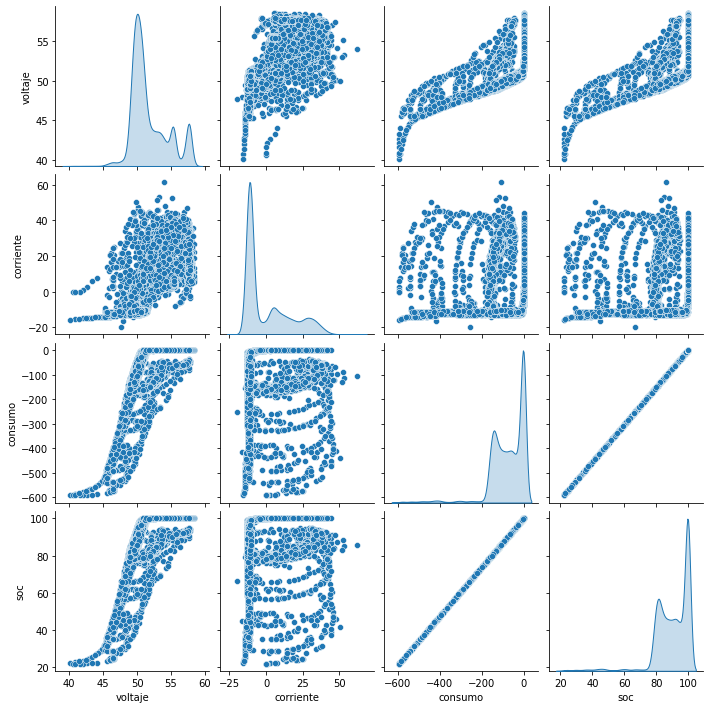

In [ ]:
sns.pairplot(entrenardataset[['voltaje','corriente','consumo','soc']],diag_kind='kde') #como se esta relacionando mis datos

In [ ]:
train_stats = entrenardataset.describe()
train_stats.pop('soc')

count    15250.000000
mean        90.119239
std         11.117949
min         22.030000
25%         83.360000
50%         92.030000
75%        100.000000
max        100.000000
Name: soc, dtype: float64

In [ ]:
train_stats = train_stats.transpose() #tranponer de filas a columnas o columnas a filas
train_stats

,count,mean,std,min,25%,50%,75%,max
voltaje,15250.0,51.717047,2.687710,40.17,49.84,50.72,53.28,58.47
corriente,15250.0,0.486446,15.649104,-19.90,-11.20,-10.40,10.60,61.80
consumo,15250.0,-75.096715,84.497365,-592.60,-126.50,-60.60,0.00,0.00


In [ ]:
temp_entrenar=entrenardataset.pop('soc') #EXTRAYENDO EL SOC TENSOR UNA COLUMNA
temp_test=testdataset.pop('soc') #EXTRAYENDO EL SOC TENSOR UNA COLUMNA

In [ ]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normentrenar = norm(entrenardataset) #normalizar y tener una sola longitud
normtest = norm(testdataset)

In [ ]:
normtest.head()

,voltaje,corriente,consumo
10,-0.471422,-0.72122,-0.092349
13,-0.508629,-0.71483,-0.187027
19,-0.579321,-0.71483,-0.378749
26,-0.661175,-0.72122,-0.602425
28,-0.683499,-0.72122,-0.666332


In [ ]:
normtest.head(1)

,voltaje,corriente,consumo
10,-0.471422,-0.72122,-0.092349


In [ ]:
normentrenar.dtypes

voltaje      float64
corriente    float64
consumo      float64
dtype: object

In [ ]:
def construir_model():
  #vamos a crear el modelo # secuencial = red neuronal/layer=conjunto de neurona
  model=keras.Sequential([layers.Dense(4,activation='sigmoid',input_shape=[len(entrenardataset.keys())]),#capa de entrada con 64 neuronas / inputsahpe=va iniciar mi neurona con la data de entrenamiento
                        layers.Dense(4, activation='sigmoid'),
                        layers.Dense(1,activation='linear')]) # capa salida
  #metodos de perdida y optimización a nuestra red neuronal para eliminar ruido en la evaluacion de la data / aprende de sus errores tratar de reducir el error
  optimizador= tf.keras.optimizers.RMSprop(0.001) #metodo RMSprop con un rango de 0.001
  model.compile(loss='mse',optimizer=optimizador,metrics=['mae','mse',tf.keras.metrics.CategoricalAccuracy()]) #se compila el modelo se genera un metodo de perdida loss = mse / estas metricas nos ayudan en el resultado / mientras menor sea el mse mejor va a predecir
  return model
model = construir_model()


In [ ]:
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

#model.fit(normentrenar,temp_entrenar,epochs=250) 


In [ ]:
model = construir_model()
# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(normentrenar, temp_entrenar, epochs=1000,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])


....................................................................................................
....................................................................................................
.........................................

In [ ]:
hista = pd.DataFrame(history.history)
hista.tail()

,loss,mae,mse,categorical_accuracy,val_loss,val_mae,val_mse,val_categorical_accuracy
236,0.007694,0.035994,0.007694,1.0,0.006998,0.032422,0.006998,1.0
237,0.007617,0.035688,0.007617,1.0,0.008436,0.044454,0.008436,1.0
238,0.007492,0.035786,0.007492,1.0,0.007588,0.033820,0.007588,1.0
239,0.007475,0.036358,0.007475,1.0,0.012043,0.073492,0.012043,1.0
240,0.007311,0.035399,0.007311,1.0,0.008071,0.032323,0.008071,1.0


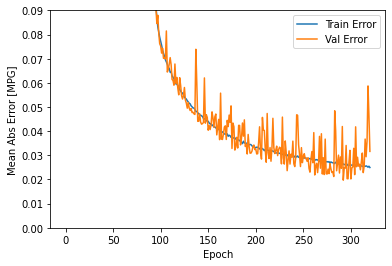

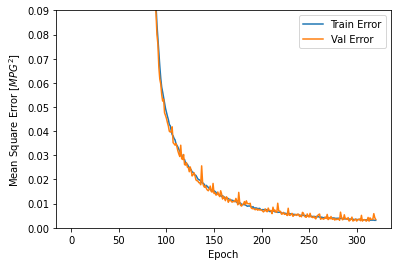

In [ ]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  plt.ylim([0,0.09])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  plt.ylim([0,0.09])
  plt.legend()
  plt.show()


plot_history(history)

In [ ]:
loss, mae, mse,accuracy = model.evaluate(normtest, temp_test, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))

120/120 - 0s - loss: 0.0032 - mae: 0.0316 - mse: 0.0032 - categorical_accuracy: 1.0000
Testing set Mean Abs Error:  0.03 MPG


In [ ]:
predicciones=model.predict(normtest).flatten()

In [ ]:
predicciones

array([89.11727 , 88.05361 , 85.88909 , ..., 98.235725, 95.18685 ,
       94.372154], dtype=float32)

In [ ]:
temp_test

10        89.09
13        88.04
19        85.91
26        83.42
28        82.71
          ...  
19037    100.00
19044     99.80
19049     98.22
19057     95.22
19059     94.41
Name: soc, Length: 3812, dtype: float64

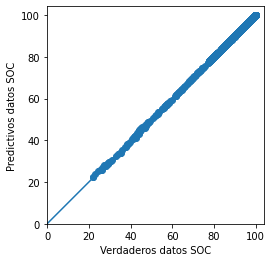

In [ ]:
plt.scatter(temp_test,predicciones)
plt.xlabel('Verdaderos datos SOC')
plt.ylabel('Predictivos datos SOC')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

In [ ]:
example1 = model.predict([[-0.478863791108416, -0.81068194064018, 0.459147039673959]])
example1

array([[95.317406]], dtype=float32)

In [ ]:
pip install tensorflowjs

     |████████████████████████████████| 71kB 6.0MB/s 
     |████████████████████████████████| 112kB 28.4MB/s 
  Found existing installation: tensorflow-hub 0.11.0
    Uninstalling tensorflow-hub-0.11.0:
      Successfully uninstalled tensorflow-hub-0.11.0


In [ ]:
import tensorflowjs as tfjs
tfjs.converters.save_keras_model(model, '/content/drive/My Drive/Go tesis/PREDICCION SOC/SOC/ModelJsUltimate/probar_js')

/usr/local/lib/python3.7/dist-packages/tensorflowjs/converters/keras_h5_conversion.py:123: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  return h5py.File(h5file)
